In [188]:
#Import some stuff... may want to un-hide me to see what's available
%matplotlib inline
import numpy as np
import scipy.spatial
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from klampt.math import vectorops,so3,se3
from klampt.model.trajectory import SE3Trajectory
import math
import random


In [283]:
class RGBDScan:
    """Represents a single RGB-D scan with optional ground truth and estimated
    transforms.
    
    Attributes:
        timestamp (float)
        rgb (np.ndarray): the RGB image, shape (h,w,3)
        depth (np.ndarray): the depth image, shape (h,w)
        T_ground_truth (klampt se3 element): the ground truth pose
        T_estimate (klampt se3 element): the estimated pose
    """
    def __init__(self,timestamp,rgb,depth,T_ground_truth=None,T_estimate=None):
        self.timestamp = timestamp
        self.rgb = rgb
        self.depth = depth
        self.T_ground_truth = T_ground_truth
        self.T_estimate = T_estimate

def _load_time_stamped_file(fn):
    """Returns a pair (times,items)"""
    with open(fn) as f:
        times = []
        items = []
        for l in f.readlines():
            l = l.strip()
            if l.startswith('#'):
                continue
            v = l.split()
            times.append(float(v[0]))
            if len(v) == 2:
                items.append(v[1])
            else:
                items.append(v[1:])
        return times,items
    raise IOError("Unable to load "+fn)
    
def load_rgbd_dataset(dataset):
    """Returns a list of RGBDScans from a folder"""
    ground_truth_t,ground_truth_transforms = _load_time_stamped_file(dataset+'/groundtruth.txt')
    ground_truth_transforms = [[float(v) for v in T] for T in ground_truth_transforms]
    #convert to Klamp't SE3 elements
    for i,trans_quat in enumerate(ground_truth_transforms):
        qx,qy,qz,qw = trans_quat[3:]
        ground_truth_transforms[i] = (so3.from_quaternion((qw,qx,qy,qz)),trans_quat[:3])
    ground_truth_path = SE3Trajectory(ground_truth_t,ground_truth_transforms)
    rgb_t,rgb_files = _load_time_stamped_file(dataset+'/rgb.txt')
    depth_t,depth_files = _load_time_stamped_file(dataset+'/depth.txt')
    depth_t = np.array(depth_t)
    scans = []
    last_ind = -1
    for t,file in zip(rgb_t,rgb_files):
        im = Image.open(dataset+'/'+file)
        rgb_array  = np.asarray(im)
        ind = np.abs(depth_t-t).argmin()
        if ind > last_ind+1:
            ind = last_ind+1
        last_ind = ind
        #print("Time",t,"Depth index",ind,"Distance",np.abs(depth_t-t)[ind])
        depth_file = depth_files[ind]
        im = Image.open(dataset+'/'+depth_file)
        depth_array  = np.asarray(im)
        T = ground_truth_path.eval_se3(t)
        scans.append(RGBDScan(t,rgb_array,depth_array,T))
    return scans

dataset = load_rgbd_dataset('rgbd_dataset')

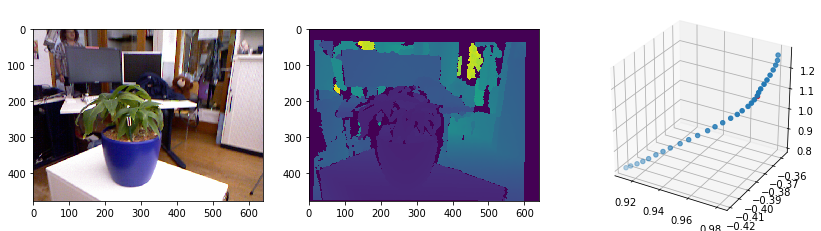

In [315]:
#Setting `shown_frame` can change which image you want to look at, from 0 to len(dataset)-1
shown_frame = 20

#do some plotting
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(dataset[shown_frame].rgb)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(dataset[shown_frame].depth)
ax3 = fig.add_subplot(1, 3, 3,projection='3d')
pts = np.asarray([s.T_ground_truth[1] for s in dataset])
ax3.scatter(pts[:,0],pts[:,1],pts[:,2])
ax3.scatter(*pts[shown_frame,:],c='r',zorder=10)

In [316]:
#Utility programs... probably don't need to change these

fx = 525.0  # focal length x
fy = 525.0  # focal length y
cx = 319.5  # optical center x
cy = 239.5  # optical center y

factor = 5000 # for the 16-bit PNG files

def depth_image_to_pc(depth_image,near_filter=0.01,far_filter=4):
    """Converts a Kinect depth image to a point cloud in camera coordinates.
    
    Points whose Z value is less than near_filter or greater than far_filter
    will be excluded.
    
    The result is an N x 3 Numpy array.
    """
    Z = depth_image * (1.0/ factor)
    X, Y = np.meshgrid(np.array(range(depth_image.shape[1]))-cx,np.array(range(depth_image.shape[0]))-cy)
    X *= Z*(1.0/fx)
    Y *= Z*(1.0/fy)
    points = np.stack((X,Y,Z),-1).reshape(depth_image.shape[0]*depth_image.shape[1],3)
    indices = np.logical_and(points[:,2] >= near_filter,points[:,2] <= far_filter).nonzero()
    return points[indices[0],:]
    """
    #Slower way
    points = []
    for v in range(depth_image.shape[0]):
        for u in range(depth_image.shape[1]):
            Z = depth_image[v,u] / factor;
            if Z < near_filter or Z > far_filter: continue;
            X = (u - cx) * Z / fx;
            Y = (v - cy) * Z / fy;
            points.append((X,Y,Z))
    return points
    """

def scan_to_pc(scan,near_filter=0.01,far_filter=4,colors=True,normals=True):
    """Converts an RGBD scan to a point cloud in camera coordinates.
    
    Points whose Z value is less than near_filter or greater than far_filter
    will be excluded.
    
    If colors=True and normals=True, the result is an N x 9 Numpy array, giving
    colors and normals.  I.e, the matrix has columns X Y Z R G B Nx Ny Nz. 
    R, G, B are in the range [0,1]
    
    If colors=True and normals=False, only the first 6 columns are returned.
    If colors=False and normals=True, only the first 3 and last 3 columns are returned.
    If colors=False and normals=False, only the X,Y,Z columns are returned.
    """
    if colors and normals:
        channels = range(9)
    elif colors:
        channels = range(6)
    elif normals:
        channels = range(3) + range(6,9)
    else:
        channels = range(3)
    h,w = scan.depth.shape[0],scan.depth.shape[1]
    Z = scan.depth * (1.0/ factor)
    X, Y = np.meshgrid(np.array(range(w))-cx,np.array(range(h))-cy)
    X *= Z*(1.0/fx)
    Y *= Z*(1.0/fy)
    points = np.stack((X,Y,Z),-1).reshape(w*h,3)
    #compute colors
    colors = (scan.rgb / 255.0).reshape(w*h,3)
    #compute normals from image
    #What's all this fuss? getting good normals in the presence of missing depth readings
    gxc = (Z[:,2:]-Z[:,:-2])/(X[:,2:]-X[:,:-2])
    gxn = (Z[:,1:]-Z[:,:-1])/(X[:,1:]-X[:,:-1])
    gyc = (Z[2:,:]-Z[:-2,:])/(Y[2:,:]-Y[:-2,:])
    gyn = (Z[1:,:]-Z[:-1,:])/(Y[1:,:]-Y[:-1,:])
    nancol = np.full((h,1),np.nan)
    gxc = np.hstack((nancol,gxc,nancol))
    gxp = np.hstack((nancol,gxn))
    gxn = np.hstack((gxn,nancol))
    gx = np.where(np.isnan(gxc),np.where(np.isnan(gxn),np.where(np.isnan(gxp),0,gxp),gxn),gxc)
    nanrow = np.full((1,w),np.nan)
    gyc = np.vstack((nanrow,gyc,nanrow))
    gyp = np.vstack((nanrow,gyn))
    gyn = np.vstack((gyn,nanrow))
    gy = np.where(np.isnan(gyc),np.where(np.isnan(gyn),np.where(np.isnan(gyp),0,gyp),gyn),gyc)
    normals = np.stack((gx,gy,-np.ones((h,w))),-1).reshape(w*h,3)
    np.nan_to_num(normals,copy=False)
    normals = normals / np.linalg.norm(normals,axis=1)[:,np.newaxis]
    np.nan_to_num(normals,copy=False)
    #join them all up
    points = np.hstack((points,colors,normals))
    #depth filtering
    indices = np.logical_and(points[:,2] >= near_filter,points[:,2] <= far_filter).nonzero()
    return points[indices[0]][:,channels]
    """
    #Slower way
    points = []
    for v in range(depth_image.shape[0]):
        for u in range(depth_image.shape[1]):
            Z = depth_image[v,u] / factor;
            if Z < near_filter or Z > far_filter: continue;
            X = (u - cx) * Z / fx;
            Y = (v - cy) * Z / fy;
            R,G,B = rgb_image[v,u] / 255.0
            up,un = max(u-1,0),min(u+1,depth_image.shape[1]-1)
            gx = (depth_image[v,un]-depth_image[v,up])/((un-up)*Z/fx)
            vp,vn = max(v-1,0),min(v+1,depth_image.shape[0]-1)
            gy = (depth_image[vn,u]-depth_image[vp,u])/((vn-vp)*Z/fy)
            N = np.array([gx,gy,-1.0])
            N /= np.linalg.norm(N)
            Nx,Ny,Nz = N
            points.append((X,Y,Z,R,G,B,Nx,Ny,Nz))
    return np.array(points)[:,channels]
    """

Point array has shape (81294, 3)


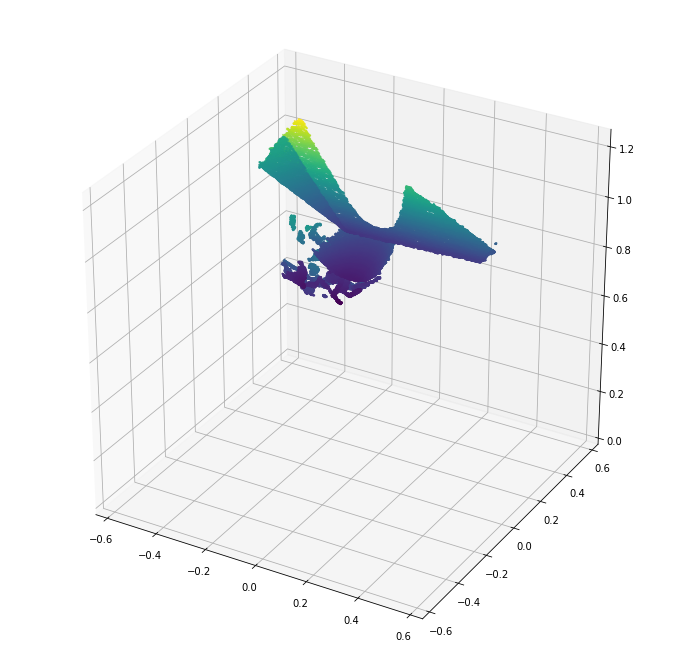

In [317]:
#plot an XYZ point cloud in the camera frame

#put a filter to select a depth range from scan 0
zlim = [0.01,1.3]
point_array = depth_image_to_pc(dataset[shown_frame].depth,zlim[0],zlim[1])
print("Point array has shape",point_array.shape)

#do the plotting 
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(point_array[:,0],point_array[:,1],point_array[:,2],s=1,c=point_array[:,2])
zmax = np.max(point_array[:,2])
ax.set_xlim([-zmax*0.5,zmax*0.5])
ax.set_ylim([-zmax*0.5,zmax*0.5])
ax.set_zlim([0,zmax])
plt.show()

In [376]:
# Question A: Implement transform_pc
def transform_pc(pc,T,point_channels=[0,1,2],normal_channels=[6,7,8]):
    """Given a point cloud `pc` and a transform T, apply the transform
    to the point cloud (in place).
    
    TODO: fill me in for Problem A.
    
    Args:
        pc (np.ndarray): an N x M numpy array, with N points and M
            channels.
        T (klampt se3 element): a Klamp't se3 element representing
            the transform to apply.
        point_channels (list of 3 ints): The channel indices (columns)
             in pc corresponding to the point data.
        normal_channels (list of 3 ints): The channels indices(columns)
            in pc corresponding to the normal data.  If this is None
            or an index is >= M, just ignore.
    
    You will need to figure out how to access Numpy arrays!
    """
    N,M = pc.shape
    assert len(point_channels) == 3
    for i in point_channels:
        assert i < M,"Invalid point_channel"
    #transform the points (you can safely assume the channel indices will be [0,1,2])
    #TODO:
    
    if normal_channels is not None and normal_channels[0] < M:
        for i in normal_channels:
            assert i < M,"Invalid normal_channel"
        #transform the normals
        #TODO:
    

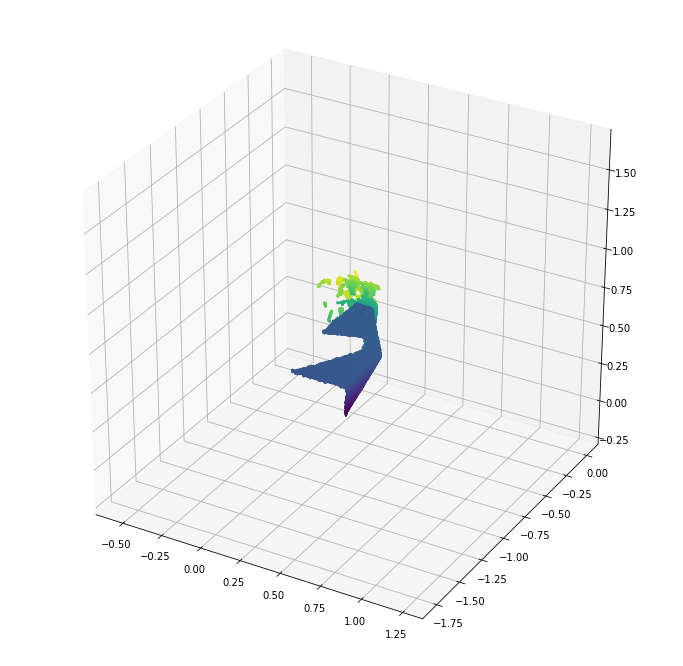

In [377]:
#Question A: test whether transform_pc works.
#Should plot the point cloud in the world frame
point_array2 = point_array.copy()
transform_pc(point_array2,dataset[shown_frame].T_ground_truth)

#do the plotting 
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(point_array2[:,0],point_array2[:,1],point_array2[:,2],s=1,c=point_array[:,2])
#uncomment next line to view from the top
#ax.view_init(elev=90, azim=0)
bmin = np.amin(point_array2,0)
bmax = np.amax(point_array2,0)
dmax = np.amax(bmax-bmin)
c = (bmin+bmax)*0.5
ax.set_xlim([c[0]-dmax*0.5,c[0]+dmax*0.5])
ax.set_ylim([c[1]-dmax*0.5,c[1]+dmax*0.5])
ax.set_zlim([c[2]-dmax*0.5,c[2]+dmax*0.5])
plt.show()

c:\python37\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Point array has shape (81121, 9)


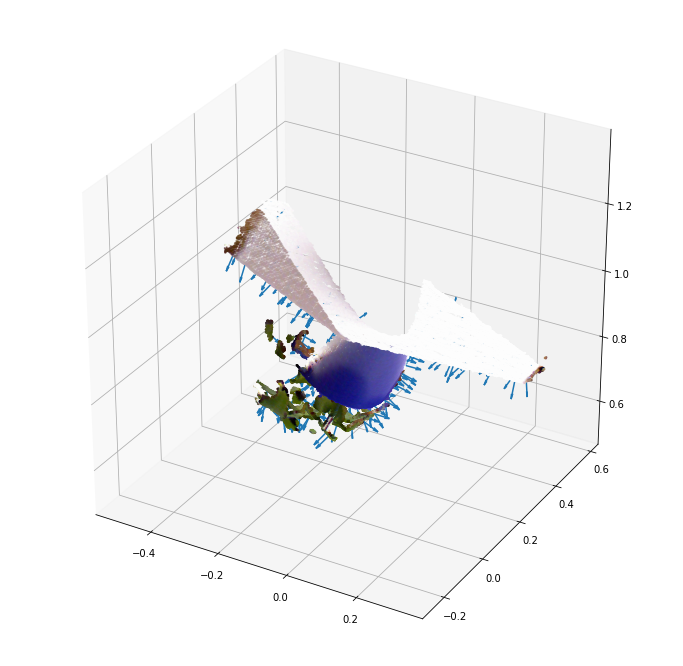

In [378]:
#plot an XYZRGB point cloud.  Question A: test whether your transform_pc
#function works with normals

#put a filter to select a depth range from scan 0
point_array = scan_to_pc(dataset[shown_frame],zlim[0],zlim[1])
print("Point array has shape",point_array.shape)

#Question A
#uncomment this line to see the transformed point cloud. Your normals should be
#calculated correctly.
transform_pc(point_array,dataset[shown_frame].T_ground_truth)

#do the plotting 
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(point_array[:,0],point_array[:,1],point_array[:,2],s=1,c=point_array[:,3:6])
inds = random.choices(range(point_array.shape[0]),k=250)
ax.quiver(point_array[inds,0],point_array[inds,1],point_array[inds,2],point_array[inds,6],point_array[inds,7],point_array[inds,8],length=0.05,normalize=False)
#uncomment next line to view from the top
#ax.view_init(elev=90, azim=0)
bmin = np.amin(point_array[:,:3],0)
bmax = np.amax(point_array[:,:3],0)
dmax = np.amax(bmax-bmin)
c = (bmin+bmax)*0.5
ax.set_xlim([c[0]-dmax*0.5,c[0]+dmax*0.5])
ax.set_ylim([c[1]-dmax*0.5,c[1]+dmax*0.5])
ax.set_zlim([c[2]-dmax*0.5,c[2]+dmax*0.5])
plt.show()

In [379]:
#Question B: implement scan merging
def merge_scans(point_clouds,transforms):
    """TODO: implement me for B.1.
    
    Arguments:
        point_clouds (list of np.ndarays): a list of point clouds
        transforms (list of klampt se3 elements): a list of point
            cloud transforms
    
    Returns: a merged point cloud, with all transforms applied.
    """
    #TODO:
    return point_clouds[0]

def merge_scans_grid(point_clouds,transforms,res=0.01):
    """TODO: implement me for B.2.
    
    Arguments:
        point_clouds (list of np.ndarays): a list of point clouds
        transforms (list of klampt se3 elements): a list of point
            cloud transforms
        res (float): the resolution of the grid
    
    Returns: a merged point cloud, with all transforms applied.
    Any point that falls within the same grid cell as an existing
    point will be discarded.
    """
    #here's a hint...
    grid = dict()
    #TODO:
    return point_clouds[0]

Merged point cloud has shape (51253, 3)


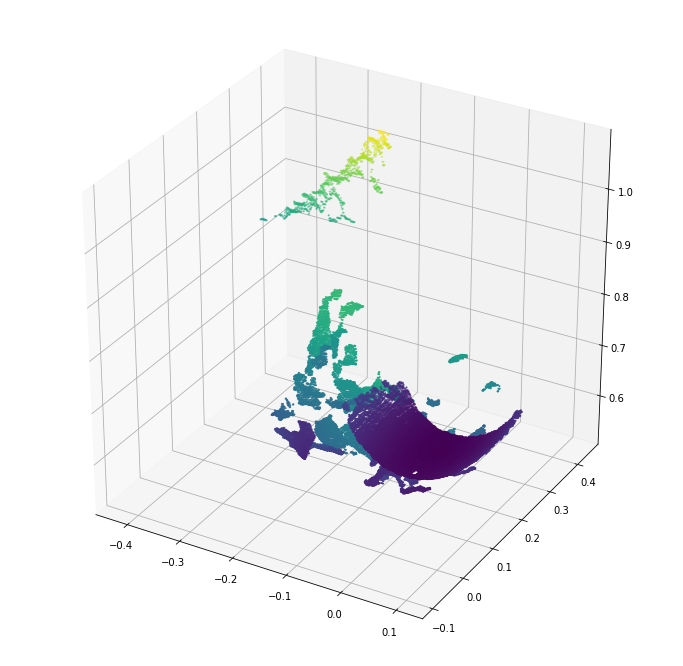

In [380]:
#Question B: play around here

N_frames = 5
#when you are ready with B part 2, uncomment the below line to try
#merging on the whole dataset.  It may take some time.
#N_frames = len(dataset)

#you might want to play around with this too...
zlim = [0.01,1.3]
pcs = [depth_image_to_pc(scan.depth,zlim[0],zlim[1]) for scan in dataset[:N_frames]]
Ts = [scan.T_ground_truth for scan in dataset]
if N_frames > 5:
    pc_merged = merge_scans_grid(pcs,Ts)
else:
    pc_merged = merge_scans(pcs,Ts)
print("Merged point cloud has shape",pc_merged.shape)

#do the plotting
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(pc_merged[:,0],pc_merged[:,1],pc_merged[:,2],s=1,c=pc_merged[:,2])
#uncomment next line to view from the top
#ax.view_init(elev=90, azim=0)
bmin = np.amin(pc_merged[:,:3],0)
bmax = np.amax(pc_merged[:,:3],0)
dmax = np.amax(bmax-bmin)
c = (bmin+bmax)*0.5
ax.set_xlim([c[0]-dmax*0.5,c[0]+dmax*0.5])
ax.set_ylim([c[1]-dmax*0.5,c[1]+dmax*0.5])
ax.set_zlim([c[2]-dmax*0.5,c[2]+dmax*0.5])
plt.show()

In [381]:
#Question C: implement ICP here

def point_fit_rotation(a,b):
    """Provides the best-fit rotation between point sets a and b.
    The points in the a list are assumed to correspond one-to-one
    to the points in the b list.
    
    Returns 3x3 Numpy array.
    """
    assert len(a)==len(b)
    A = np.asarray(a).T
    B = np.asarray(b).T
    BAt = np.dot(B,A.T)
    U,W,Vt = np.linalg.svd(BAt)
    R = np.dot(U,Vt)
    return R

def point_fit_transform(a,b):
    """Provides the best-fit rigid transform between point sets a and b.
    
    Returns a pair (R,t) giving a 3x3 Numpy array and 3-D Numpy vector.
    """
    assert len(a)==len(b)
    A = np.asarray(a).T
    B = np.asarray(b).T
    amean = np.average(A,axis=1)
    bmean = np.average(B,axis=1)
    A = A - np.column_stack([amean]*len(a))
    B = B - np.column_stack([bmean]*len(b))
    BAt = np.dot(B,A.T)
    U,W,Vt = np.linalg.svd(BAt)
    R = np.dot(U,Vt)
    return R,bmean-np.dot(R,amean)

def point_plane_fit_transform_klampt(a,b,bnormals):
    """Provides the best-fit point-to-plane rigid transform between
    point sets a and b, with bnormals giving the normals at points
    b.  The objective function is
    
    E(R,t) = sum(p in a, q in b, n in bnormals) (n^T (R*a + t - b))^2
        
    Returns a pair (R,t) as a klampt se3 element
    """
    import scipy.optimize
    A = np.asarray(a).T
    B = np.asarray(b).T
    N = np.asarray(bnormals).T
    def func(x):
        w = x[:3]
        t = x[3:]
        R = np.array(so3.matrix(so3.from_rotation_vector(w)))
        D = np.dot(R,A) + t[:,np.newaxis] - B
        diff = 0
        for i in range(N.shape[1]):
            #diff += abs(np.dot(N[:,i],D[:,i])) #sum of absolute errors
            diff += (np.dot(N[:,i],D[:,i]))**2  #sum of squared errors
        return diff
    res = scipy.optimize.minimize(func,np.zeros(6))
    w = res.x[:3]
    t = res.x[3:]
    print("Initial point/plane avg error",func(np.zeros(6))/len(a))
    print("Final point/plane avg error",res.fun/len(a))
    return so3.from_rotation_vector(w),t.tolist()
        

def point_fit_rotation_klampt(a,b):
    """Same as point_fit_rotation, but returns a klampt so3 element"""
    R = point_fit_rotation(a,b)
    return R.T.flatten().tolist()

def point_fit_transform_klampt(a,b):
    """Same as point_fit_transform, but returns a klampt se3 element"""
    R,t = point_fit_transform(a,b)
    return (R.T.flatten().tolist(),t.tolist())

def point_fit_error_klampt(a,b,T):
    """Returns the sum of squared errors for the transform fit T"""
    diffs = [vectorops.sub(se3.apply(T,p),q) for (p,q) in zip(a,b)]
    return sum(vectorops.dot(d,d) for d in diffs)

def icp_unstructured(source_pc,target_pc,N_iters,T_guess=None):
    """Question C: this is the main ICP framework.  Implement
    and tweak the TODO below!
    
    Performs iterative closest points on two unstructured
    point clouds.
    
    Returns a Klampt se3 element representing the transform from
    the source to the target frame, e.g., find T such that
    
       T*source_pc ~= target_pc
    
    Arguments:
        source_pc (np.ndarray): the source point cloud
        target_pc (np.ndarray): the target point cloud
        N_iters (int): the number of ICP iterations
        T_guess (klampt se3 element, optional): the initial
            guess for the source point cloud transform
    """
    #the current value of the optimized transform
    T = se3.identity()
    #current_source maintains the source point cloud with T applied
    current_source = source_pc.copy()
    #If a guess is provided, use that
    if T_guess is not None:
        T = T_guess
        transform_pc(current_source,T_guess)
    #construct the fast nearest-neighbors data structure for the target point cloud
    
    kdtree_positions = scipy.spatial.KDTree(target_pc[:,:3])
    #to get the closest distances and indices of a set of points xs to the target point cloud,
    #you can use this (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query)
    #d,i = kdtree_positions.query(xs)
    
    #if you want to experiment with using all 9 point features, you can
    #use this code.  color_scale modifies the color channels, and normal_scale
    #modifies the normal channels.
    #
    #color_scale = 0.1
    #normal_scale = 0.05
    #target_pc_scaled = target_pc.copy()
    #target_pc_scaled[:,3:6] *= color_scale
    #target_pc_scaled[:,6:9] *= normal_scale
    #kdtree_all = scipy.spatial.KDTree(target_pc_scaled)
    #
    #To get the closest distances and indices of a set of points xs to the target point cloud, you can
    #use this.
    #xs[:,3:6] *= color_scale
    #xs[:,6:9] *= normal_scale
    #d,itgt = kdtree_all.query(xs)
    
    inds = random.choices(range(current_source.shape[0]),k=500)
    #begin the main loop
    for i in range(N_iters):
        #1. Detect matches from current_source to target_pc.
        #This should also handle outlier rejection
        
        #TODO: implement me
        #Suggest A) subsampling source_pc to 500-2000 points
        #B) finding the closest points to those points in target_pc.
        #C) sorting by distance and rejecting some fraction of outliers
        matches = [(0,0),(1,1),(2,2),(3,3)]
        
        #2. Find the optimal transform from current_source to target_pc.
        #This uses point-to-point distances
        source_points = [current_source[a,:3] for (a,b) in matches]
        target_points = [target_pc[b,:3] for (a,b) in matches]
        #RMSE: root-mean-squared error
        old_rmse = math.sqrt(point_fit_error_klampt(source_points,target_points,se3.identity())/len(source_points))
        if old_rmse < 1e-6:
            print("Converged! RMSE",old_rmse,"Total rotation",so3.angle(T[0]),"translation",vectorops.norm(T[1]))
            break
        T_diff = point_fit_transform_klampt(source_points,target_points)
        new_rmse = math.sqrt(point_fit_error_klampt(source_points,target_points,T_diff)/len(source_points))
        print("Iteration",i,"matches",len(matches),"points, RMSE",old_rmse,"->",new_rmse)
        if abs(new_rmse-old_rmse) < 1e-8:
            print("No progress, breaking")
            break
        
        #3. Accumulate the fitted transform
        transform_pc(current_source,T_diff)
        T = se3.mul(T_diff,T)
    
    #return the optimized transform
    return T


c:\python37\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


World model has 51253 points
Matching frame 5 to model
Iteration 0 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 1 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 2 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 3 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 4 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 5 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 6 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 7 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 8 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 9 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 10 matches 4 points, RMSE 0.042881937235405135 -> 0.012813242758899878
Iteration 11 matches 4 points, RMSE 0.042881937235405135 -> 0.01

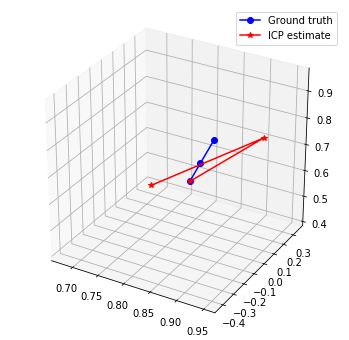

In [382]:
#do repeated ICP and compare against ground truth
#N_frames = 5
#N_frames = len(dataset)
N_frames = 3
frame_skip = 5
#frame_skip = 1
frame_indices = range(0,N_frames*frame_skip,frame_skip)

zlim = [0.01,1.2]
world_model = merge_scans_grid([scan_to_pc(dataset[0],zlim[0],zlim[1])],[dataset[0].T_ground_truth])
print("World model has",world_model.shape[0],"points")
dataset[frame_indices[0]].T_estimate = dataset[frame_indices[0]].T_ground_truth
for i,p in zip(frame_indices[1:],frame_indices[:-1]):
    #NO CHEATING: clear out the ground truth
    T_gt = dataset[i].T_ground_truth
    dataset[i].T_ground_truth = None
    
    print("Matching frame",i,"to model")
    source_pc = scan_to_pc(dataset[i],zlim[0],zlim[1])
    try:
        #Ti = icp_unstructured(source_pc,world_model,10,T_gt)
        Ti = icp_unstructured(source_pc,world_model,20,dataset[p].T_estimate)
    except Exception:
        dataset[i].T_ground_truth = T_gt
        raise
    except KeyboardInterrupt:
        dataset[i].T_ground_truth = T_gt
        raise
    dataset[i].T_estimate = Ti
    world_model = merge_scans_grid([world_model,source_pc],[se3.identity(),dataset[i].T_estimate])
    print("Model now contains",world_model.shape[0],"points")
    
    #restore the ground truth
    dataset[i].T_ground_truth = T_gt

pts_gt = np.asarray([dataset[i].T_ground_truth[1] for i in frame_indices])
pts_es = np.asarray([dataset[i].T_estimate[1] for i in frame_indices])
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot(pts_gt[:,0],pts_gt[:,1],pts_gt[:,2],c='b',marker="o",label="Ground truth")
ax.plot(pts_es[:,0],pts_es[:,1],pts_es[:,2],c='r',marker="*",label="ICP estimate")
ax.legend()
plt.show()

c:\python37\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


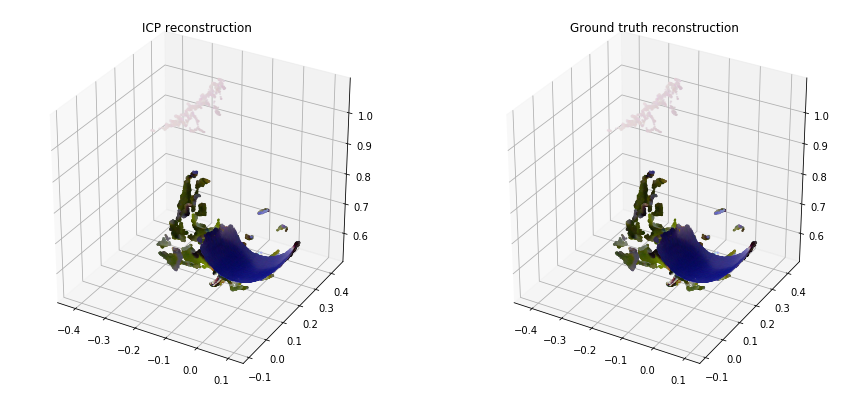

In [383]:
#Plot the merged world model
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
#ax.scatter(world_model[:,0],world_model[:,1],world_model[:,2],s=1,c=world_model[:,2])
ax.scatter(world_model[:,0],world_model[:,1],world_model[:,2],s=1,c=world_model[:,3:6])
#uncomment next line to view from the top
#ax.view_init(elev=90, azim=0)
bmin = np.amin(world_model[:,:3],0)
bmax = np.amax(world_model[:,:3],0)
dmax = np.amax(bmax-bmin)
c = (bmin+bmax)*0.5
ax.set_xlim([c[0]-dmax*0.5,c[0]+dmax*0.5])
ax.set_ylim([c[1]-dmax*0.5,c[1]+dmax*0.5])
ax.set_zlim([c[2]-dmax*0.5,c[2]+dmax*0.5])
ax.set_title("ICP reconstruction")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
gt_world_model = merge_scans_grid([scan_to_pc(dataset[i],zlim[0],zlim[1]) for i in frame_indices],
                                  [dataset[i].T_ground_truth for i in frame_indices])
#ax2.scatter(gt_world_model[:,0],gt_world_model[:,1],gt_world_model[:,2],s=1,c=gt_world_model[:,2])
ax2.scatter(gt_world_model[:,0],gt_world_model[:,1],gt_world_model[:,2],s=1,c=gt_world_model[:,3:6])
ax2.set_xlim([c[0]-dmax*0.5,c[0]+dmax*0.5])
ax2.set_ylim([c[1]-dmax*0.5,c[1]+dmax*0.5])
ax2.set_zlim([c[2]-dmax*0.5,c[2]+dmax*0.5])
ax2.set_title("Ground truth reconstruction")
plt.show()